In [35]:
from tqdm import tqdm
import pickle
import PIL.Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import transforms, datasets

%matplotlib inline

# Table of Contents

* [Preprocessing](#Preprocessing)
* [Model](#Model)
* [Training](#Training)

# Preprocessing

In [2]:
with open('./Vision_task_dataset_public/train_image.pkl', 'rb') as f:
    images = pickle.load(f)
images = np.array(images)
images.shape

(8000, 784)

In [3]:
with open('./Vision_task_dataset_public/train_label.pkl', 'rb') as f:
    labels = pickle.load(f)
labels = np.array(labels)
labels.shape

(8000,)

### Labels: 4

In [17]:
np.unique(labels)

array([0, 2, 3, 6])

In [39]:
labels[0], labels[2000], labels[4000], labels[7999]

(0, 2, 3, 6)

### Images

In [20]:
images[0], labels[0]

(array([  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,  41, 188, 103,
         54,  48,  43,  87, 168, 133,  16,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   1,   0,   0,   0,  49, 136, 219, 216,
        228, 236, 255, 255, 255, 255, 217, 215, 254, 231, 160,  45,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  14, 176, 222, 224,
        212, 203, 198, 196, 200, 215, 204, 202, 201, 201, 201, 209, 218,
        224, 164,   0,   0,   0,   0,   0,   0,   0,   0,   0, 188, 219,
        200, 198, 202, 198, 199, 199, 201, 196, 198, 198, 200, 200, 200,
        200, 201, 200, 225,  41,   0,   0,   0,   0,   0,   0,   0,  51,
        219, 199, 203, 203, 212, 238, 248, 250, 245, 249, 246, 247, 252,
        248, 235, 207, 203, 203, 222, 140,   0,   0,   0,   0,   0,   0,
          0, 116, 226, 206, 204, 207, 204, 101,  75,  47,  73,  48,  50,
         45,  51,  63, 113, 222, 202, 206, 220, 224,   0,   0,   0,   0,
          0,   0,   0, 200, 222, 209, 203, 215, 200

In [7]:
images[0].shape

(784,)

In [38]:
np.sqrt(784)

28.0

It seems that every image is a square of size 28x28.

(28, 28)


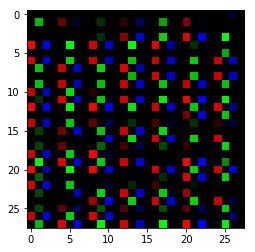

In [81]:
img = images[0].reshape(28, 28)
print(img.shape)
img = PIL.Image.fromarray(img, mode='RGB')
plt.imshow(img)

(28, 28)


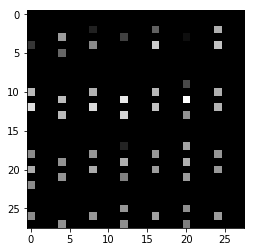

In [69]:
img = images[4000].reshape(28, 28)
print(img.shape)
img = PIL.Image.fromarray(img, mode='L')
plt.imshow(img)

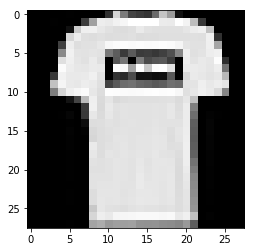

In [93]:
plt.imshow(images[0].reshape(1, 28, 28).squeeze(), cmap='Greys_r')

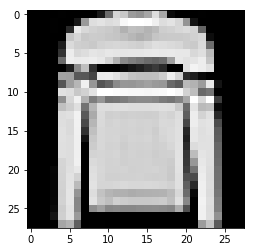

In [102]:
plt.imshow(images[2000].reshape(28, 28), cmap='Greys_r')

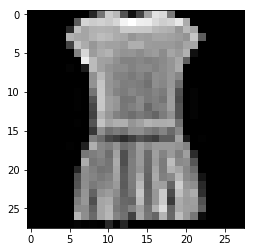

In [95]:
plt.imshow(images[4000].reshape(1, 28, 28).squeeze(), cmap='Greys_r')

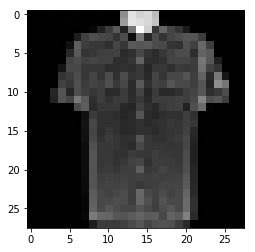

In [96]:
plt.imshow(images[7999].reshape(1, 28, 28).squeeze(), cmap='Greys_r')

In [117]:
images = images.astype(np.float32)

In [118]:
tensor_X = torch.stack([torch.from_numpy(np.array(i)) for i in images])
tensor_y = torch.stack([torch.from_numpy(np.array(i)) for i in labels])

In [119]:
tensor_X.dtype, tensor_y.dtype

(torch.float32, torch.int64)

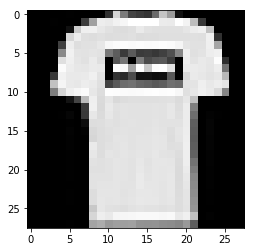

In [120]:
plt.imshow(tensor_X[0].reshape(1, 28, 28).squeeze(), cmap='Greys_r')

In [121]:
X_train, X_test, y_train, y_test = train_test_split(tensor_X, tensor_y, test_size=0.2, random_state=0)

TypeError: take(): argument 'index' (position 1) must be Tensor, not numpy.ndarray

---
Not working as sklearn `train_test_split` doesn't take tensor as input, but numpy array.

**Solution:** first split data then convert into tensor

In [147]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=0)

In [148]:
X_train = torch.stack([torch.from_numpy(np.array(i)) for i in X_train])
X_test = torch.stack([torch.from_numpy(np.array(i)) for i in X_test])
y_train = torch.stack([torch.from_numpy(np.array(i)) for i in y_train])
y_test = torch.stack([torch.from_numpy(np.array(i)) for i in y_test])

In [149]:
X_train = X_train.reshape((-1, 1, 28, 28))
X_test = X_test.reshape((-1, 1, 28, 28))

In [154]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [155]:
len(train_loader)

100

In [156]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [157]:
dataiter = iter(train_loader)
tt, ll = dataiter.next()
print(type(ll))
print(tt.shape)
print(ll.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Now, everything seems perfect!  
Ready to move on...

# Model

# Training